In [1]:
# uncomment these two lines if using a gpu for a speedup
# from desc import set_device
# set_device("gpu")

In [ ]:
# imports
import numpy as np
from desc.coils import CoilSet, FourierPlanarCoil
from desc.plotting import plot_surfaces, plot_3d, plot_coils
from desc.grid import LinearGrid, ConcentricGrid
from desc.objectives import (
    ObjectiveFunction,
    # coil
    CoilCurvature,
    CoilLength,
    CoilSetMinDistance,
    PlasmaCoilSetMinDistance,
    CoilSetLinkingNumber,
    # plasma
    FixPressure,
    FixCurrent,
    FixPsi,
    ForceBalance,
    QuasisymmetryTwoTerm,
    BoundaryError,
    RotationalTransform,
    MeanCurvature,
)
from desc.optimize import Optimizer
import plotly.io as pio

# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "plotly_mimetype"

In [3]:
# plotting
from desc.plotting import (
    plot_boozer_surface,
    plot_qs_error,
)

In [38]:
##################################
# Generating initial equilibrium #
##################################
from desc.examples import get
from desc.profiles import PowerSeriesProfile

eq_init = get("precise_QA")
# truncate
eq_init.change_resolution(M=1, N=1)
eq_init.change_resolution(L=6, L_grid=12, M=4, N=4, M_grid=12, N_grid=12)
eq_init.set_initial_guess()
# add pressure to make beta ~ 0.5%
eq_init.pressure = PowerSeriesProfile([1, -1], modes=[0, 2])
current_beta = eq_init.compute(["<beta>_vol"])["<beta>_vol"]
target_beta = 0.005
p0 = target_beta / current_beta
eq_init.pressure = PowerSeriesProfile([p0, -p0], modes=[0, 2])
eq_init.solve()
orig_eq = eq_init.copy()

/Users/dpanici/Research/DESC/desc/utils.py:572: UserWarning:

Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`

/Users/dpanici/Research/DESC/desc/equilibrium/initial_guess.py:226: UserWarning:

Surfaces from initial guess are not nested, attempting to refine coordinates. This may take a few moments.



Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 241
Number of objectives: 2450

Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied. (ftol=1.00e-02)
         Current function value: 2.678e-06
         Total delta_x: 2.256e-01
         Iterations: 7
         Function evaluations: 10
         Jacobian evaluations: 8
                                                                 Start  -->   End
Total (sum of squares):                                      9.864e-02  -->   2.678e-06, 
Maximum absolute Force error:        

In [39]:
print(eq_init.compute(["<beta>_vol"])["<beta>_vol"])

0.0049818671760451


(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

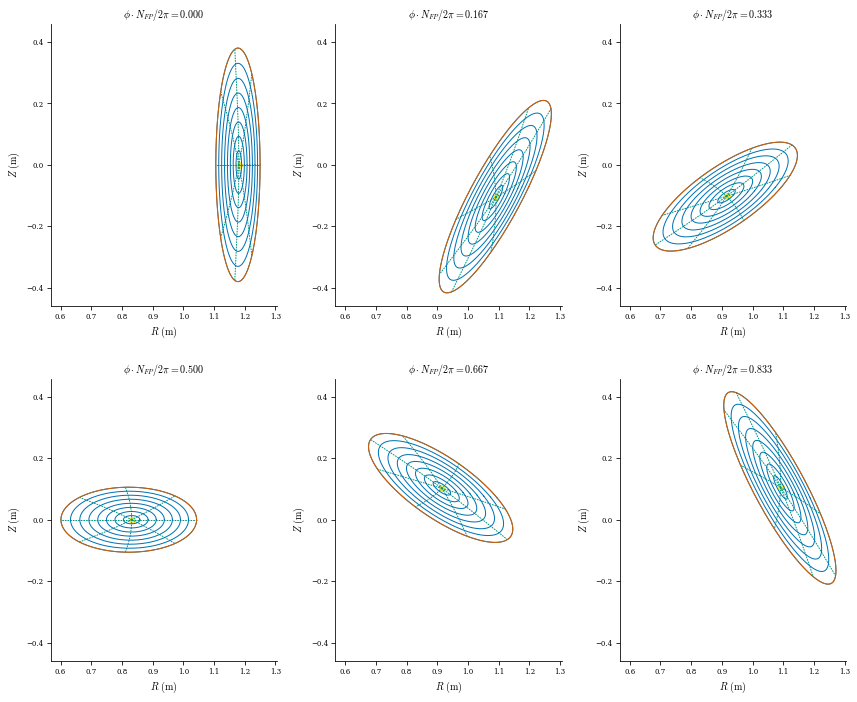

In [40]:
plot_surfaces(eq_init)

(<Figure size 432.324x432.324 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

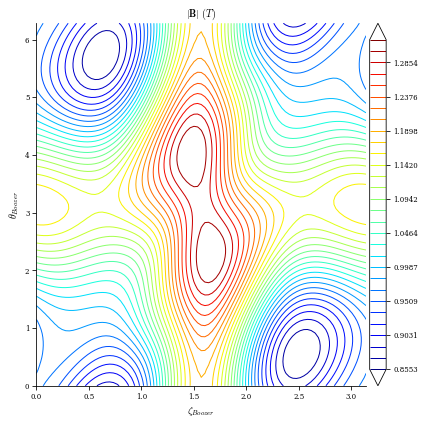

In [41]:
plot_boozer_surface(eq_init)

In [42]:
##############################
# Generating initial coilset #
##############################

minor_radius = eq_init.compute("a")["a"]
offset = 0.5
num_coils = 4  # coils per half field period

zeta = np.linspace(0, np.pi / eq_init.NFP, num_coils, endpoint=False) + np.pi / (
    2 * eq_init.NFP * num_coils
)
grid = LinearGrid(rho=[0.0], M=0, zeta=zeta, NFP=eq_init.NFP)
data = eq_init.axis.compute(["x", "x_s"], grid=grid, basis="rpz")

centers = data["x"]  # center coils on axis position
normals = data["x_s"]  # make normal to coil align with tangent along axis

# coils need to obey a certain current due to ampere's law, initialize with
# the correct currents
from scipy.constants import mu_0

tot_req_current = 2 * np.pi * eq_init.compute("G")["G"][-1] / mu_0 / eq_init.NFP / 2


unique_coils = []
for k in range(num_coils):
    coil = FourierPlanarCoil(
        current=tot_req_current
        / num_coils
        / 2
        / eq_init.NFP,  # /2 bc sym, /NFP for the field periods
        center=centers[k, :],
        normal=normals[k, :],
        r_n=minor_radius + offset,
        basis="rpz",  # we are giving the center and normal in cylindrical coordinates
    ).to_FourierXYZ(
        N=5
    )  # fit with 10 fourier coefficients per coil
    unique_coils.append(coil)

# We package these coils together into a CoilSet, which has efficient methods for calculating
# the total field while accounting for field period and stellarator symmetry
# Note that `CoilSet` requires all the member coils to have the same parameterization and resolution.
# if we wanted to use coils of different types or resolutions, we can use a `MixedCoilSet` (see the next section below)
coilset = CoilSet(unique_coils, NFP=eq_init.NFP, sym=eq_init.sym)

In [59]:
fig = plot_3d(eq_init, "|B|", grid=LinearGrid(M=20, N=20, endpoint=True))
plot_coils(coilset, fig=fig)

/Users/dpanici/Research/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/Users/dpanici/Research/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [44]:
coilset.coils

[FourierXYZCoil at 0x49695c640 (name=, current=88377.70655438422),
 FourierXYZCoil at 0x49695eea0 (name=, current=88377.70655438422),
 FourierXYZCoil at 0x49695e2c0 (name=, current=88377.70655438422),
 FourierXYZCoil at 0x49695efd0 (name=, current=88377.70655438422)]

In [47]:
grid_vol = ConcentricGrid(
    L=eq_init.L_grid,
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
)

grid_lcfs = LinearGrid(
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
    rho=np.array(1.0),
)

coil_grid = LinearGrid(N=40)
plasma_grid = LinearGrid(M=20, N=20, NFP=eq_init.NFP, sym=eq_init.sym)

# to use this constraint to enforce satisfying Ampere's law for the targeted equilibrium during optimization,
from desc.objectives import LinkingCurrentConsistency

obj_currs = LinkingCurrentConsistency(eq_init, coilset, weight=100)


coil_indices_to_fix_current = [False for c in coilset]
coil_indices_to_fix_current[0] = True
constraints = (
    ForceBalance(eq=eq_init),
    FixPressure(
        eq=eq_init
    ),  # fix pressure profile (i.e. dont let it change during optimization)
    FixPsi(
        eq=eq_init
    ),  # fix total toroidal magnetic flux (i.e. dont let it change during optimization)
    FixCurrent(eq=eq_init),  # Fix current (i.e. dont let it change during optimization)
)

obj = ObjectiveFunction(
    (
        BoundaryError(
            eq=eq_init,  # this objective is both quadratic flux AND boundary magnetic pressure, i.e.
            # the objectives for free bdry in vacuum (zero quad flux and continuous B^2 across bdry)
            field=coilset,
            field_grid=coil_grid,
            grid=plasma_grid,
            weight=2e2,
        ),
        obj_currs,
        MeanCurvature(
            eq=eq_init, grid=plasma_grid, bounds=(-30, 30)
        ),  # to make sure equilibrium does not develop sharp corners
        QuasisymmetryTwoTerm(
            eq=eq_init, helicity=(1, 0), grid=grid_lcfs, weight=10
        ),  # our QS objective
        RotationalTransform(
            eq=eq_init, target=0.37, weight=1.25e2, grid=grid_lcfs
        ),  # choose an irrational number to avoid islands in the magnetic field
        CoilSetMinDistance(
            coilset,
            # in normalized units, want coil-coil distance to be at least 10% of minor radius
            bounds=(0.1, np.inf),
            normalize_target=False,  # we're already giving bounds in normalized units
            grid=coil_grid,
            weight=200,
        ),
        PlasmaCoilSetMinDistance(
            eq_init,
            coilset,
            # in normalized units, want plasma-coil distance to be at least 25% of minor radius
            bounds=(0.25, np.inf),
            normalize_target=False,  # we're already giving bounds in normalized units
            plasma_grid=plasma_grid,
            coil_grid=coil_grid,
            eq_fixed=False,  # Fix the equilibrium. For single stage optimization, this would be False
            weight=200,
        ),
        CoilCurvature(
            coilset,
            # this uses signed curvature, depending on whether it curves towards
            # or away from the centroid of the curve, with a circle having positive curvature.
            # We give the bounds normalized units, curvature of approx 1 means circular,
            # so we allow them to be a bit more strongly shaped
            bounds=(-1, 2),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=75,
        ),
        CoilLength(
            coilset,
            bounds=(0, 2 * np.pi * (minor_radius + offset)),
            normalize_target=True,  # target length is in meters, not normalized
            grid=coil_grid,
            weight=80,
        ),
        CoilSetLinkingNumber(coilset, grid=LinearGrid(N=5), weight=5e1),
    ),
    # jac_chunk_size=50,
)

In [48]:
optimizer = Optimizer("proximal-lsq-exact")

(
    eq_qs_T,
    optimized_coilset,
), result_T = optimizer.optimize(
    (eq_init, coilset),
    objective=obj,
    constraints=constraints,
    ftol=1e-4,  # stopping tolerance on the function value
    xtol=1e-8,  # stopping tolerance on the step size
    gtol=1e-8,  # stopping tolerance on the gradient
    maxiter=40,  # maximum number of iterations
    options={
        "perturb_options": {"order": 2, "verbose": 0},  # use 2nd-order perturbations
        "solve_options": {
            "ftol": 1e-2,
            "xtol": 1e-6,
            "gtol": 1e-6,
            "verbose": 0,
        },  # for equilibrium subproblem
    },
    copy=True,  # copy=True to make a copy of the optimized result and dont touch the orignals
    verbose=3,
)

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 96.6 ms
Building objective: linking current
Building objective: mean curvature
Precomputing transforms
Timer: Precomputing transforms = 187 ms
Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 187 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 54.8 ms
Building objective: coil-coil minimum distance
Building objective: plasma-coil minimum distance
Building objective: coil curvature
Precomputing transforms
Timer: Precomputing transforms = 88.7 ms
Building objective: coil length
Precomputing transforms
Timer: Precomputing transforms = 6.35 ms
Building objective: coil-coil linking number
Timer: Objective build = 5.50 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 234 ms
Timer: Objective build = 262 ms
Timer: Objective build = 1.28 ms
Timer: Eq Update LinearConstraintPro

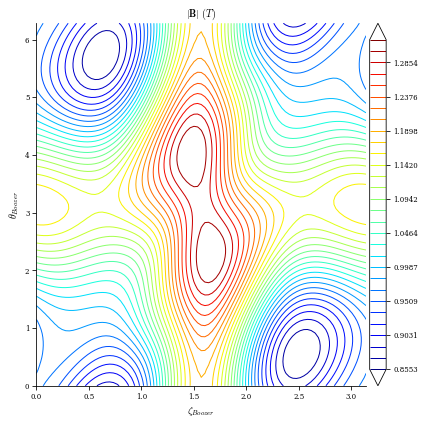

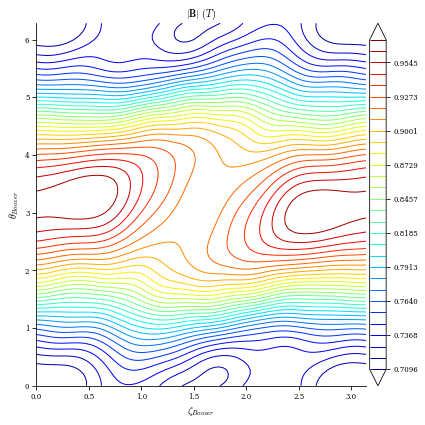

In [49]:
plot_boozer_surface(eq_init)
plot_boozer_surface(eq_qs_T);  # |B| contours at rho=1 surface

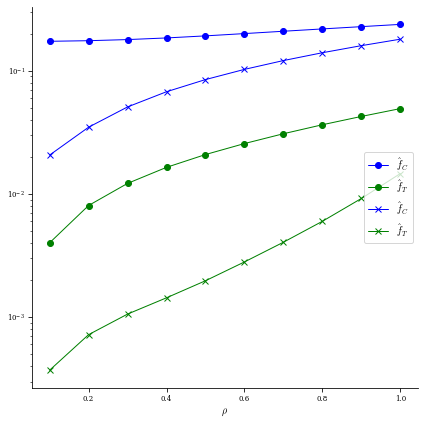

In [50]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fB=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_T, helicity=(1, eq_qs_T.NFP), fB=False, ax=ax, marker=["x", "x"], rho=10
);

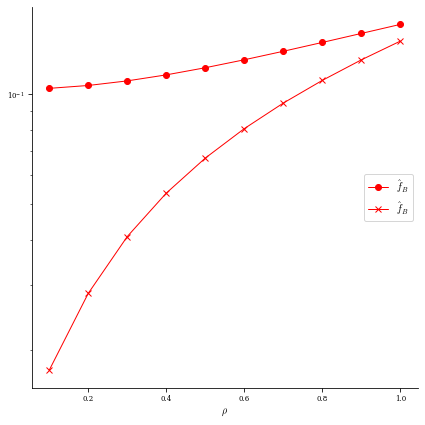

In [51]:
# compare f_B before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fT=False, fC=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_T, helicity=(1, eq_qs_T.NFP), fT=False, fC=False, ax=ax, marker=["x"], rho=10
);

In [60]:
fig = plot_3d(
    eq_qs_T.surface,
    "B*n",
    field=optimized_coilset,
    alpha=0.5,
    grid=LinearGrid(M=20, N=20, endpoint=True),
)  # pass in surface so the Bplasma is not computed, as it is vacuum
plot_coils(optimized_coilset, fig=fig)
# plot_coils(coilset,fig=fig,color="red")

(<Figure size 288.216x288.216 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\iota ~(~)$'>)

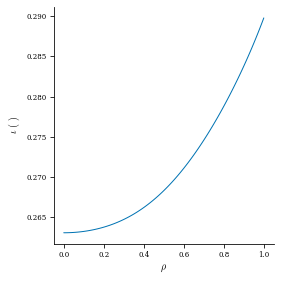

In [53]:
from desc.plotting import *

plot_1d(eq_qs_T, "iota")

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

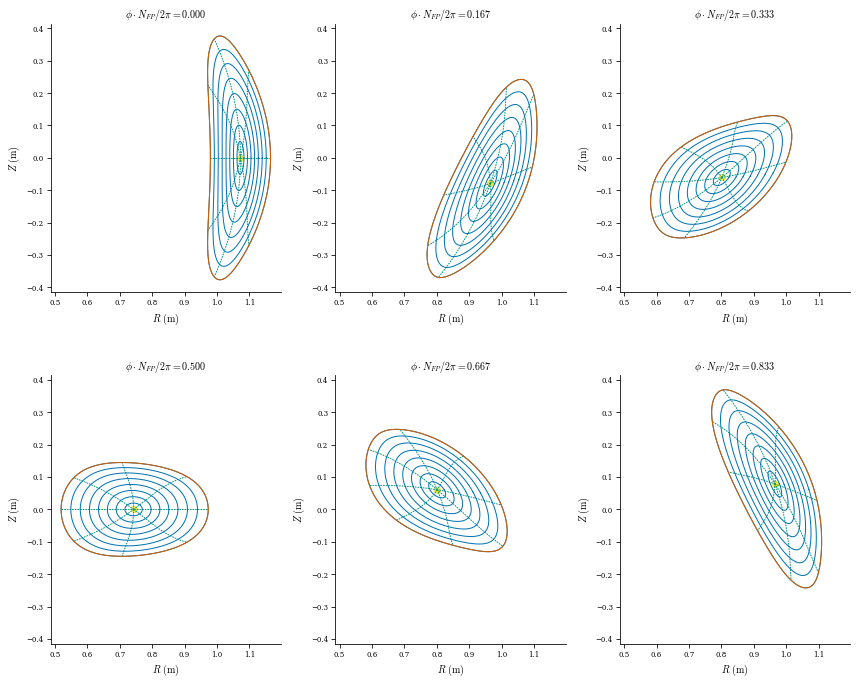

In [54]:
plot_surfaces(eq_qs_T)

In [55]:
# solve free bdry at end

eq_freeb = eq_qs_T.copy()

eq_freeb.change_resolution(
    L=8, L_grid=16, N=8, N_grid=16  # increase L for accuracy
)  # increase N to capture some of the coil ripple effects

constraints = (
    ForceBalance(eq=eq_freeb),
    FixPressure(
        eq=eq_freeb
    ),  # fix pressure profile (i.e. dont let it change during optimization)
    FixPsi(
        eq=eq_freeb
    ),  # fix total toroidal magnetic flux (i.e. dont let it change during optimization)
    FixCurrent(
        eq=eq_freeb
    ),  # Fix current (i.e. dont let it change during optimization)
)

obj = ObjectiveFunction(
    (
        BoundaryError(
            eq=eq_freeb,  # this objective is both quadratic flux AND boundary magnetic pressure, i.e.
            # the objectives for free bdry in vacuum (zero quad flux and continuous B^2 across bdry)
            field=optimized_coilset,
            field_grid=coil_grid,
            grid=plasma_grid,
            field_fixed=True,
        )
    ),
    jac_chunk_size=25,
)

eq_freeb.optimize(objective=obj, constraints=constraints, ftol=1e-3, verbose=3);

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 27.0 ms
Timer: Objective build = 195 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 84.1 ms
Timer: Objective build = 99.6 ms
Timer: Objective build = 1.13 ms
Timer: Eq Update LinearConstraintProjection build = 199 ms
Timer: Proximal projection build = 728 ms
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Timer: Objective build = 62.7 ms
Timer: LinearConstraintProjection build = 143 ms
Number of parameters: 153
Number of objectives: 1650
Timer: Initializing the optimization = 967 ms

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.681e-03                                    1.429e-02   
       1              4          1.026e-03      1.655e-03      8.612e-03      2.126e-02   
 

(<Figure size 864.648x720.54 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

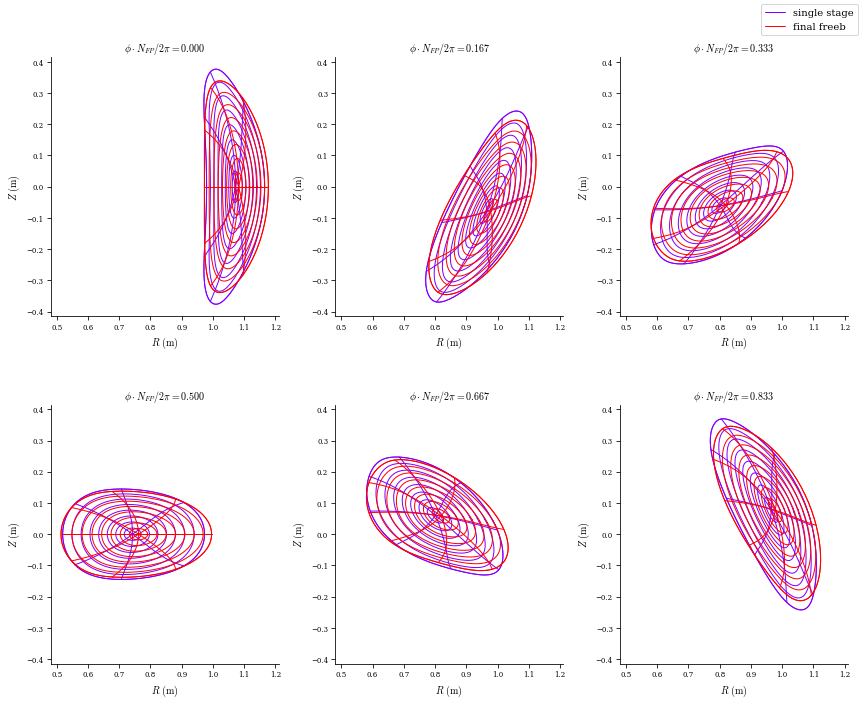

In [56]:
plot_comparison([eq_qs_T, eq_freeb], labels=["single stage", "final freeb"])

(<Figure size 432.324x432.324 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

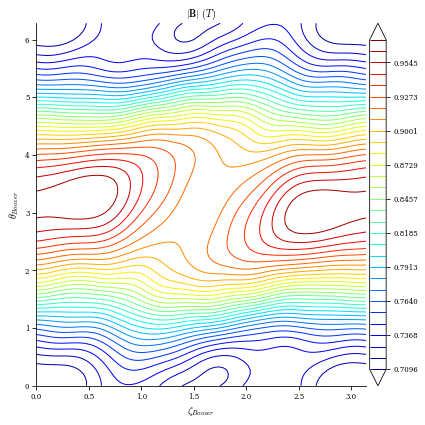

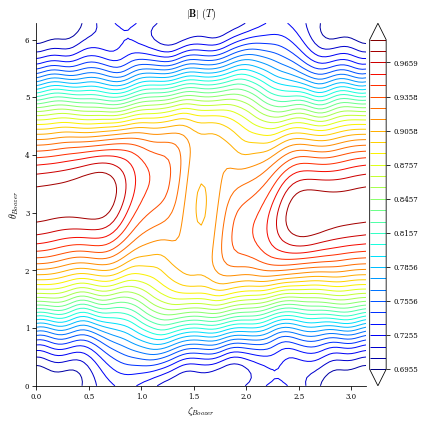

In [57]:
plot_boozer_surface(eq_qs_T)
# |B| contours at rho=1 surface
plot_boozer_surface(eq_freeb)

/Users/dpanici/Research/DESC/desc/utils.py:520: FutureWarning:

argument linecolor has been renamed to color, linecolor will be removed in a future release



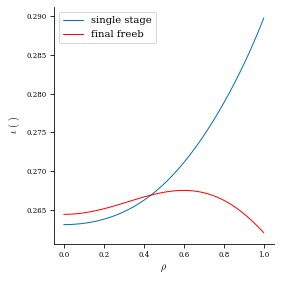

In [58]:
fig, ax = plot_1d(eq_qs_T, "iota", label="single stage")
fig, ax = plot_1d(eq_freeb, "iota", label="final freeb", ax=ax, linecolor="r")
ax.legend()